**Идея решения**

1. Есть два подавляюще больших класса ,которые надо предсказывать. Поэтому отсекаем количество данных менье 15К

Бустинг не зашёл

Описание столбцов для train и test:
● id -  уникальный идентификатор столбца;

● ticket_id - уникальный идентификатор билета, считается, что у одного
билета один владелец

● ticket_type_nm - тип билета

● entrance_id - уникальный id входа в станцию

● entrance_nm -  название

● station_id - уникальное id станции захода

● station_nm - наименование станции захода

● line_id - уникальный id ветки на, которой находится станция

● line_nm - наименование ветки, на которой находится станция

● pass_dttm - дата валидации

● time_to_under (столбец для предсказания) - сколько времени прошло
между первой и второй валидацией

● label (столбец для предсказания) -  id второй станции, на которой
произошла валидация


## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate


%matplotlib inline

import lightgbm as lgb


from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, scoring=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# plot_learning_curve(clf, '--', X.values, y['label'].values, cv=3, n_jobs=-1, scoring='recall_macro')



In [2]:
def modifydata(df, val = None):
#     id not a feature. Test and train имеют разные Идшники, поэтому там ерунду будет прогнозить
    id_col = df['id'].copy()
    df = df.drop("id", axis=1)

    
#     Сделаем категорию **"ticket_type_nm"** ранговой 
    df["ticket_type_nm"] = pd.Categorical(df["ticket_type_nm"])
    df["ticket_type_nm"].astype('category').cat.codes
    df["ticket_type_nm"] = df["ticket_type_nm"].cat.codes
    
#     Видоизменим категорию "pass_dttm"
    df["day"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[0]))
    df["hours"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[0]))

#     Меняем типы, чтобы уменьшить объём занимаемой памяти:
    df['hours'] = df['hours'].astype('int8')
    df['day'] = df['day'].astype('int8')
    df['line_id'] = df['line_id'].astype('int8')
    df['ticket_type_nm'] = df['ticket_type_nm'].astype('int8')
    df['entrance_id'] = df['entrance_id'].astype('int16')
    df['entrance_id'] = df['entrance_id'].astype('int16')

    df['time'] = pd.to_datetime(df['pass_dttm'])
    df['time_isweekend'] = (df['time'].dt.dayofweek // 5 == 1).astype('int8')
    df['time_dayofweek'] = df['time'].dt.dayofweek.astype('int8')

#     df = df[df["time_to_under"] < 900]   # для классификации надо чтобы были все данные. Для регрессии не важно

    if 'label' in df.columns:
# классы, которые полохо класифицируются
        temp = df["label"].value_counts() < val 
        bad_classes = temp.index[temp.values]

        is_bad_classes = df['label'].isin(bad_classes)
        df_bad_classes = df.drop( df[ ~is_bad_classes].index)
        df_good_classes = df.drop( df[is_bad_classes].index)
#         df_bad_classes = df.drop( df[ ~is_bad_classes].index)

        return df, df_bad_classes, df_good_classes, id_col
    
    else:
        return df, id_col
    


def getFeaturesAndOutput(df):
    if 'time_to_under' in df.columns:
        X = df.drop(["ticket_id", "entrance_nm", "station_nm", "line_nm", "pass_dttm", "label","time_to_under", 'time'], axis = 1)
        y = df[["time_to_under", "label"]]
        return X,y
    else:
        X = valid.drop(["ticket_id", "entrance_nm", "station_nm", "line_nm", "pass_dttm", 'time'], axis = 1)
        return X

In [3]:
def modifydata2(df, val = None):
#     id not a feature. Test and train имеют разные Идшники, поэтому там ерунду будет прогнозить
    id_col = df['id'].copy()
    df = df.drop("id", axis=1)

    
#     Сделаем категорию **"ticket_type_nm"** ранговой 
    df["ticket_type_nm"] = pd.Categorical(df["ticket_type_nm"])
    df["ticket_type_nm"].astype('category').cat.codes
    df["ticket_type_nm"] = df["ticket_type_nm"].cat.codes
    
#     Видоизменим категорию "pass_dttm"
    df["day"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[0]))
    df["hours"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[0]))

#     Меняем типы, чтобы уменьшить объём занимаемой памяти:
    df['hours'] = df['hours'].astype('int8')
    df['day'] = df['day'].astype('int8')
    df['line_id'] = df['line_id'].astype('int8')
    df['ticket_type_nm'] = df['ticket_type_nm'].astype('int8')
    df['entrance_id'] = df['entrance_id'].astype('int16')
    df['entrance_id'] = df['entrance_id'].astype('int16')

    df['time'] = pd.to_datetime(df['pass_dttm'])
    df['time_isweekend'] = (df['time'].dt.dayofweek // 5 == 1).astype('int8')
    df['time_dayofweek'] = df['time'].dt.dayofweek.astype('int8')

#     df = df[df["time_to_under"] < 900]   # для классификации надо чтобы были все данные. Для регрессии не важно

    if 'label' in df.columns:
        # классы, которые полохо класифицируются
        temp = df["label"].value_counts() < val 
        bad_classes = temp.index[temp.values]

        is_bad_classes = df['label'].isin(bad_classes)
        df_bad_classes = df.drop( df[ ~is_bad_classes].index)
        df_good_classes = df.drop( df[is_bad_classes].index)

        df_good_classes_fulldata = df.copy()
        df_good_classes_fulldata['newlabel'] = df_good_classes_fulldata['label']
        df_good_classes_fulldata.loc[is_bad_classes.values, 'newlabel'] = -1

        return df, df_bad_classes, df_good_classes, id_col, df_good_classes_fulldata
    
    else:
        return df, id_col   


def get_random_classes(df, nskip, nclasses, nlen, seed):
    # nskip, nclasses, nlen, seed = 2,10,100,13
    np.random.seed(seed)
    cs = np.cumsum(df["label"].value_counts()[nskip:nclasses].values)
    val = np.random.randint(1, cs[-1], size=nlen)

    keys = df["label"].value_counts()[nskip:nclasses].index

    ans = []
    for i in range(nlen):
        for j in range(len(cs)-1):
    #         print(val[i], cs[j], cs[j+1])
            if (val[i] > cs[j]) & (val[i] < cs[j+1]):
                ans.append(keys[j])
    return ans

# temp = get_random_classes(df, 2, 30, df.shape[0], 13)

##  подгрузка данных

In [4]:
# df = pd.read_csv("./train_dataset_train.csv", nrows = 100000)
df = pd.read_csv("./train_dataset_train.csv")
valid = pd.read_csv("./test_dataset_test.csv")

df, df_bad_classes, df_good_classes, id_col = modifydata(df, None)
valid, _ = modifydata(valid, None)

print(df_bad_classes.shape, df_good_classes.shape, df.shape)

(0, 16) (1091021, 16) (1091021, 16)


## Рассмотрим датасет по ближе

In [89]:
df.head(3)

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,day,hours,time,time_isweekend,time_dayofweek
0,40BD89EC85646EFB69E283F39C298E60,40,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,12,5,2022-09-12 05:00:13,0,0
1,126727A96489CC976A8C08E5CEB00542,53,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011,12,5,2022-09-12 05:00:54,0,0
2,D28CE6A9E0E5B6D213470A97CFF32485,26,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022,12,5,2022-09-12 05:00:55,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1074830 entries, 0 to 1091020
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   id              1074830 non-null  int64         
 1   ticket_id       1074830 non-null  object        
 2   ticket_type_nm  1074830 non-null  int8          
 3   entrance_id     1074830 non-null  int16         
 4   entrance_nm     1074830 non-null  object        
 5   station_id      1074830 non-null  int64         
 6   station_nm      1074830 non-null  object        
 7   line_id         1074830 non-null  int8          
 8   line_nm         1074830 non-null  object        
 9   pass_dttm       1074830 non-null  object        
 10  time_to_under   1074830 non-null  float64       
 11  label           1074830 non-null  int64         
 12  day             1074830 non-null  int8          
 13  hours           1074830 non-null  int8          
 14  time            10

In [7]:
df.describe()

,id,ticket_type_nm,entrance_id,station_id,line_id,time_to_under,label,day,hours,time_isweekend,time_dayofweek
count,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06
mean,5.459673e+05,2.580051e+01,8.596997e+02,8.602768e+03,8.591321e+00,5.033546e+02,7.722615e+03,1.479729e+01,9.361641e+00,2.350604e-01,2.795979e+00
std,3.150992e+05,1.951754e+01,9.009391e+02,1.247817e+04,1.247842e+01,2.268707e+02,1.167184e+04,1.942422e+00,3.360137e+00,4.240368e-01,1.941946e+00
min,1.000000e+00,0.000000e+00,2.000000e+01,1.002000e+03,1.000000e+00,3.001667e+01,1.002000e+03,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.727602e+05,5.000000e+00,2.150000e+02,3.017000e+03,3.000000e+00,3.179500e+02,3.006000e+03,1.300000e+01,7.000000e+00,0.000000e+00,1.000000e+00
50%,5.464905e+05,1.900000e+01,3.390000e+02,7.009000e+03,7.000000e+00,5.645500e+02,6.013000e+03,1.500000e+01,8.000000e+00,0.000000e+00,3.000000e+00
75%,8.181888e+05,3.800000e+01,2.087000e+03,9.022000e+03,9.000000e+00,6.771667e+02,9.012000e+03,1.600000e+01,1.100000e+01,0.000000e+00,4.000000e+00
max,1.091021e+06,5.900000e+01,2.466000e+03,8.101600e+04,8.100000e+01,8.999833e+02,8.101600e+04,1.900000e+01,2.300000e+01,1.000000e+00,6.000000e+00


<AxesSubplot:>

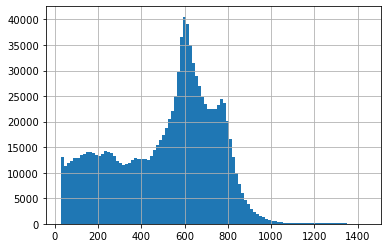

In [69]:
df["time_to_under"].hist(bins = 100)

### **"ticket_type_nm"** 


In [13]:
df["ticket_type_nm"].value_counts()

38    258626
5     173197
57    125905
3     114987
19     57185
10     48340
16     46096
6      44197
51     39033
25     29256
11     24166
14     20548
53     16793
55     15439
17     12663
40      8851
52      6691
54      3148
4       3062
26      2793
48      2572
35      2532
23      2522
58      2261
20      2215
24      1543
9       1249
15      1159
49      1143
7       1033
44       865
12       765
43       533
45       506
2        497
50       353
30       335
56       243
59       229
18       182
37       159
22       141
0        122
29       110
42       108
21        92
31        61
27        60
34        56
8         49
39        44
46        33
13        29
41        24
47        10
1          7
36         6
32         2
33         2
28         2
Name: ticket_type_nm, dtype: int64

<AxesSubplot:xlabel='ticket_type_nm', ylabel='count'>

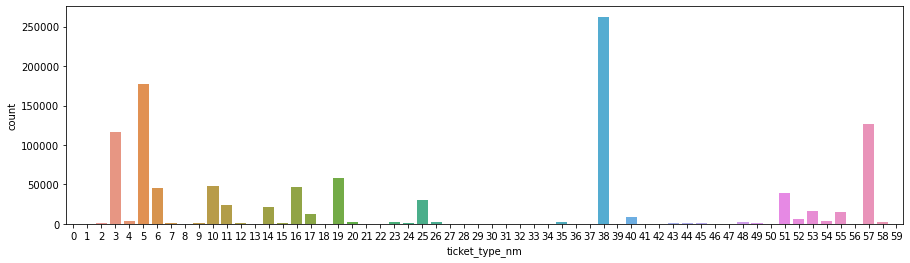

In [25]:
plt.figure(figsize=(15,4))
sns.countplot(x = "ticket_type_nm" , data  = df)  

Кажется нет четкой зависимости между категорией билета и временем между заходи на станцию

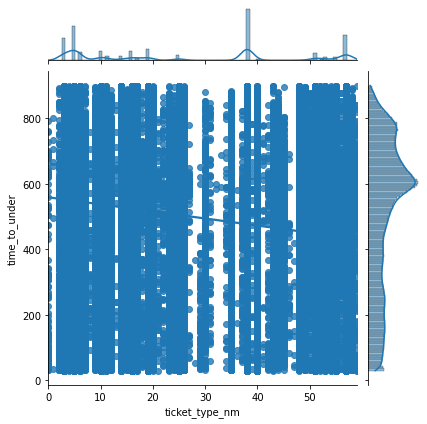

In [15]:
sns.jointplot(x = "ticket_type_nm", y = 'time_to_under', data = df, kind = 'reg')

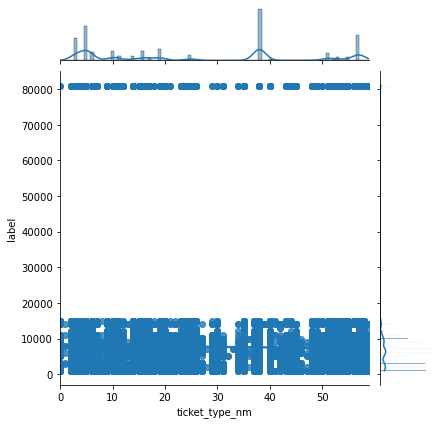

In [16]:
sns.jointplot(x = "ticket_type_nm", y = 'label', data = df, kind = 'reg')

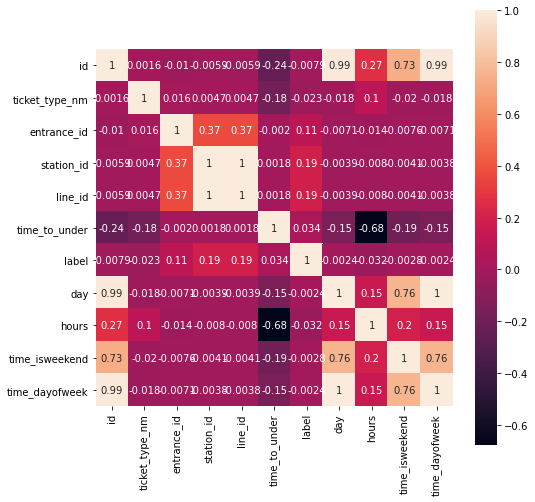

In [235]:
plt.figure(figsize=(8,8))
corr = df.corr()
g = sns.heatmap(corr, square = True, annot=True)

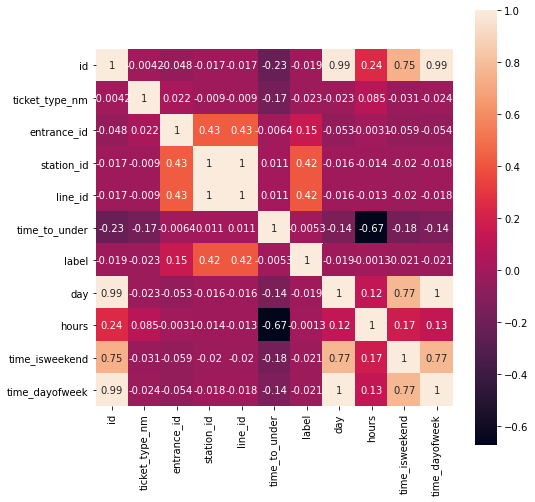

In [236]:
plt.figure(figsize=(8,8))
corr = df_bad_classes.corr()
g = sns.heatmap(corr, square = True, annot=True)

# Classification

Посмотрим на распределение двух основных величин 

<AxesSubplot:>

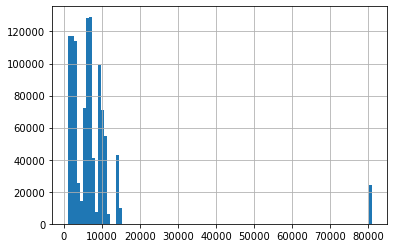

In [8]:
df["label"].hist(bins = 100)

Найдем наиболее популярную станцию и посмотрим инфо по ней:

In [48]:
df["label"].value_counts()[:20]

3002    17272
6008    15541
1022    13758
5010    13122
7022    13080
7015    12704
1009    12353
5009    11507
6006    11220
8001    10091
6020     9820
1018     9245
2001     9225
7020     9077
6010     8931
5001     8764
5007     8580
3010     8564
2003     8414
8007     8288
Name: label, dtype: int64

In [297]:
numstate = 2
print(df["label"].value_counts().index[numstate] )  # номер станции

df[df["label"] == int(df["label"].value_counts().index[ numstate ])].head()

1022


,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,day,hours,time,time_isweekend,time_dayofweek
144,1F82115E616F773706774F4D9C12D51D,3,297,Выхино ( Второй ),7004,Выхино,7,Таганско-Краснопресненская,2022-09-12 05:25:29,720.733333,1022,12,5,2022-09-12 05:25:29,0,0
344,4352DEBD7FB7568E95205A8DF6DE9B87,57,21,Бульвар Рокоссовского ( Южный ),1002,Бульвар Рокоссовского,1,Сокольническая,2022-09-12 05:30:06,792.033333,1022,12,5,2022-09-12 05:30:06,0,0
375,B448669F088958AEDCD4073BE50F61AB,38,2263,Некрасовка (Первый),15002,Некрасовка,15,Некрасовская,2022-09-12 05:30:12,913.583333,1022,12,5,2022-09-12 05:30:12,0,0
799,5E0B371FBF8EF3B68A623A331CC8693E,3,205,Павелецкая К,5009,Павелецкая,5,Кольцевая,2022-09-12 05:33:45,666.683333,1022,12,5,2022-09-12 05:33:45,0,0
1063,A75B9E82C5F1BFFA426D45C7BB2BFBAC,51,44,Охотный ряд ( Южный ),1009,Охотный ряд,1,Сокольническая,2022-09-12 05:36:56,912.983333,1022,12,5,2022-09-12 05:36:56,0,0


Количество классов

266 / 10


Text(0.5, 0, 'Index')

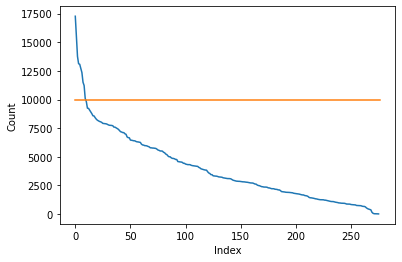

In [53]:
thrval = 10000
print(np.sum(df["label"].value_counts() < thrval), '/', np.sum(df["label"].value_counts() > thrval))


plt.plot(df["label"].value_counts().values)
plt.plot([0, len(df["label"].value_counts())], [thrval, thrval])   # уровень, который отрезаем
plt.ylabel('Count')
plt.xlabel('Index')

In [20]:
df['hours'].value_counts()

8     232006
7     208545
9     141080
6     116616
10     77730
11     54940
12     42521
13     38645
14     32010
15     28072
5      24494
16     24333
17     22807
18     18796
19     10576
0       8919
20      4732
21      1918
1        840
22       765
2        316
4        147
3        132
23        81
Name: hours, dtype: int64

In [45]:
for c in ['ticket_type_nm', 'entrance_id', 'station_id', 'line_id', 'time_to_under', 
          'day', 'hours','time_isweekend', 'time_dayofweek']:
    print('\n', c, ':\n', df[c].value_counts())


 ticket_type_nm :
 38    262499
5     177041
57    127022
3     117064
19     58071
10     48658
16     46542
6      45381
51     39395
25     29674
11     24307
14     20859
53     16933
55     15551
17     12817
40      9234
52      6744
54      3169
4       3098
26      2829
48      2634
35      2555
23      2535
58      2272
20      2258
24      1549
9       1264
15      1173
49      1166
7       1045
44       869
12       768
43       541
45       510
2        504
50       361
30       335
56       244
59       233
18       188
37       159
22       142
0        123
29       113
42       113
21        92
31        61
27        60
34        56
8         49
39        44
46        34
13        30
41        24
47        10
1          7
36         6
32         2
33         2
28         2
Name: ticket_type_nm, dtype: int64

 entrance_id :
 153     17810
303     13530
2263    12205
2043    11963
218     11949
        ...  
2116       16
2111       10
2115        9
2114        8
2420    

In [46]:
df['station_id'].value_counts()[-100:]

14018    1545
81002    1532
4009     1503
11006    1487
6008     1434
         ... 
13005      20
13001      16
13006      10
13004       9
13002       8
Name: station_id, Length: 100, dtype: int64

### Группы станций

Смотрим, чем отличаются статистики по станциям

In [40]:
gp = df.groupby("label")

# id count
# 3002    17272
# 6008    15541
# 1022    13758
# 5010    13122
# 7022    13080
# 7015    12704
# 1009    12353
# 5009    11507
# 6006    11220
# 8001    10091
# 6020     9820
# 1018     9245
# 2001     9225
# 7020     9077
# 6010     8931
# 5001     8764
# 5007     8580
# 3010     8564
# 2003     8414
# 8007     8288

In [51]:
g3002 = gp.get_group(3002)
g6008 = gp.get_group(6008)
g1022 = gp.get_group(1022)
g5010 = gp.get_group(5010)
g7022 = gp.get_group(7022)

<AxesSubplot:>

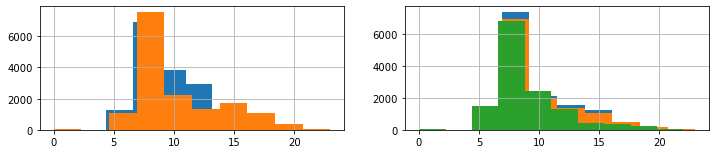

In [69]:
plt.figure(figsize=(12,5))
plt.subplot(221)
g3002['hours'].hist()
g6008['hours'].hist()

plt.subplot(222)
g1022['hours'].hist()
g5010['hours'].hist()
g7022['hours'].hist()

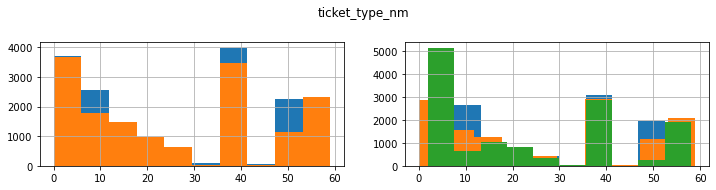

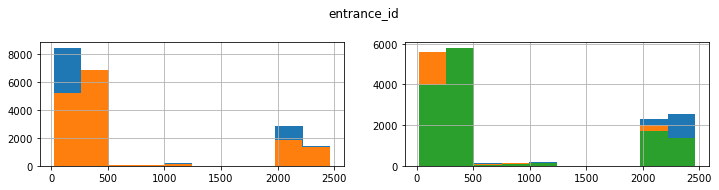

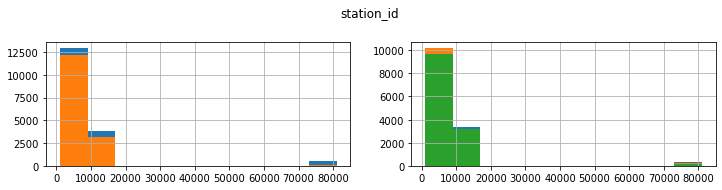

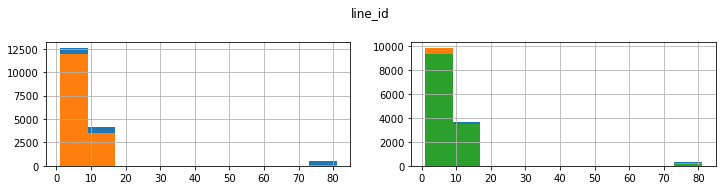

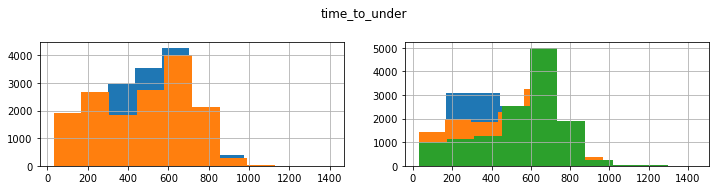

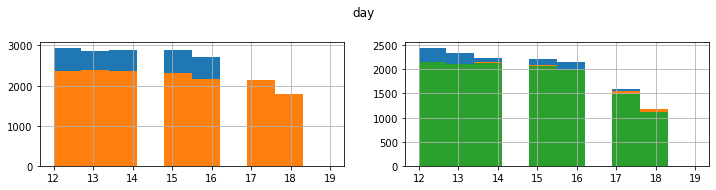

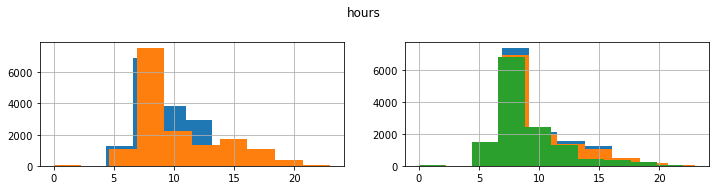

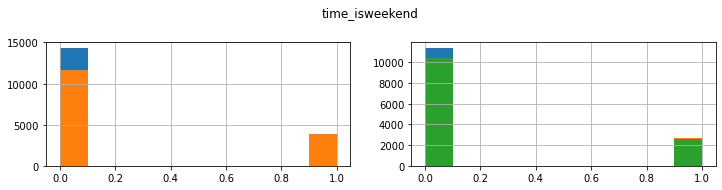

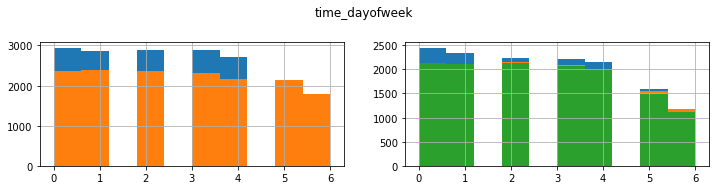

In [79]:
for c in ['ticket_type_nm', 'entrance_id', 'station_id', 'line_id', 'time_to_under', 
          'day', 'hours','time_isweekend', 'time_dayofweek']:
    plt.figure(figsize=(12,5))
    plt.suptitle(c)
    plt.subplot(221)
    g3002[c].hist()
    g6008[c].hist()

    plt.subplot(222)
    g1022[c].hist()
    g5010[c].hist()
    g7022[c].hist()


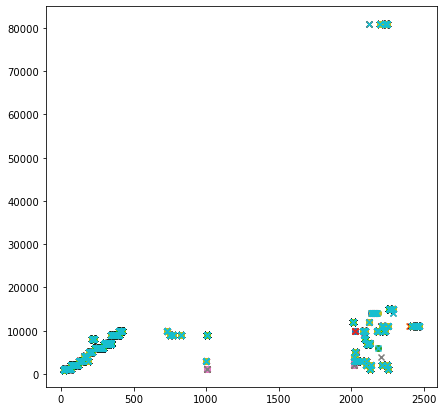

In [100]:
# for c in ['ticket_type_nm', 'entrance_id', 'station_id', 'line_id', 'time_to_under', 
#           'day', 'hours','time_isweekend', 'time_dayofweek']:
# plt.figure(figsize=(7,7))
# for g in [g3002, g6008, g1022, g5010, g7022]:
#     plt.scatter(g['ticket_type_nm'], g['entrance_id'])
    
plt.figure(figsize=(7,7))
for g in [g3002, g6008, g1022, g5010, g7022]:
    plt.scatter(g[g['time_isweekend']==1]['entrance_id'], g[g['time_isweekend']==1]['station_id'])
    plt.scatter(g[g['time_isweekend']==0]['entrance_id'], g[g['time_isweekend']==0]['station_id'], marker='x')
    
# plt.figure(figsize=(7,7))
# for g in [g3002, g6008, g1022, g5010, g7022]:
#     plt.scatter(g['time_isweekend'], g['hours'])


In [81]:
df_bad_classes.columns

Index(['id', 'ticket_id', 'ticket_type_nm', 'entrance_id', 'entrance_nm',
       'station_id', 'station_nm', 'line_id', 'line_nm', 'pass_dttm',
       'time_to_under', 'label', 'day', 'hours', 'time', 'time_isweekend',
       'time_dayofweek'],
      dtype='object')

<AxesSubplot:xlabel='station_id', ylabel='Count'>

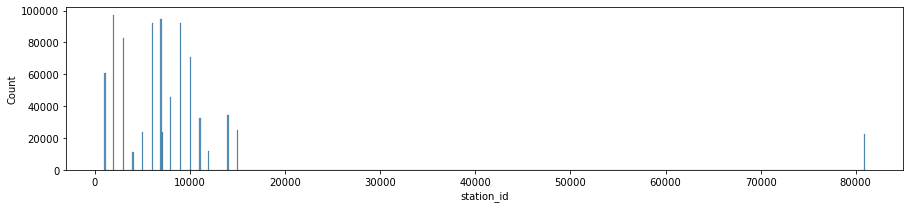

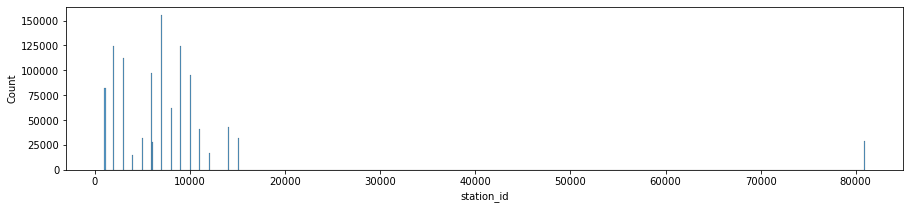

In [105]:
plt.figure(figsize=(15,3))
sns.histplot(df_bad_classes['station_id'])

plt.figure(figsize=(15,3))
sns.histplot(df['station_id'])

In [70]:
valid.columns

Index(['id', 'ticket_id', 'ticket_type_nm', 'entrance_id', 'entrance_nm',
       'station_id', 'station_nm', 'line_id', 'line_nm', 'pass_dttm', 'day',
       'hours', 'time', 'time_isweekend', 'time_dayofweek'],
      dtype='object')

## Сравнение выборок

In [ ]:
df["id"].hist(bins = 100)
valid["id"].hist(bins = 100)

<AxesSubplot:>

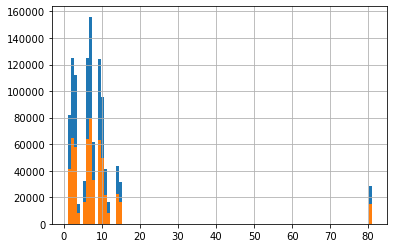

In [72]:
df["line_id"].hist(bins = 100)
valid["line_id"].hist(bins = 100)

<AxesSubplot:>

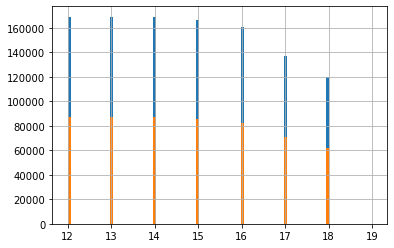

In [73]:
df["day"].hist(bins = 100)
valid["day"].hist(bins = 100)

<AxesSubplot:>

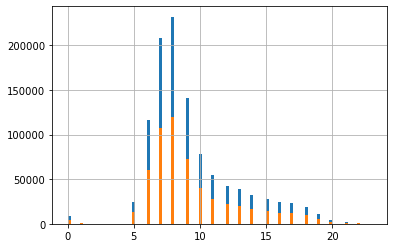

In [74]:
df["hours"].hist(bins = 100)
valid["hours"].hist(bins = 100)

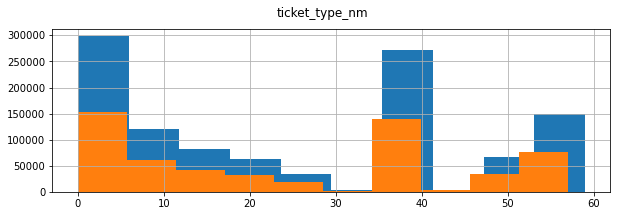

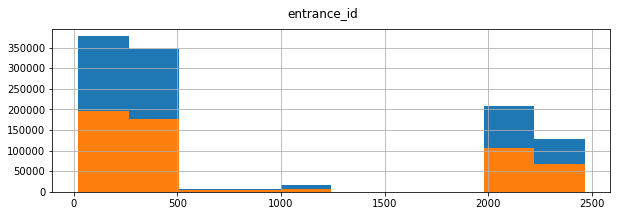

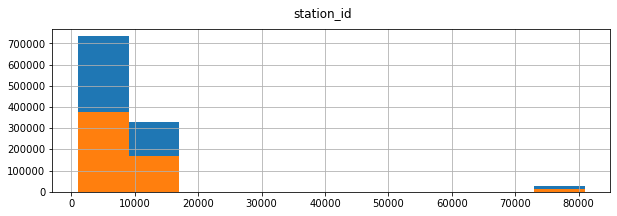

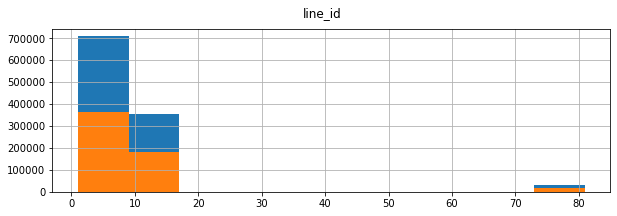

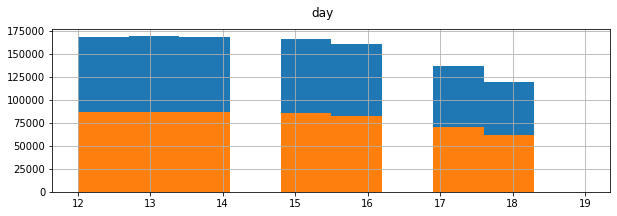

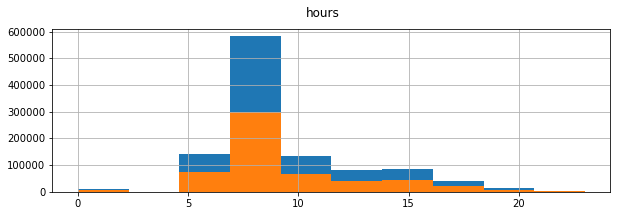

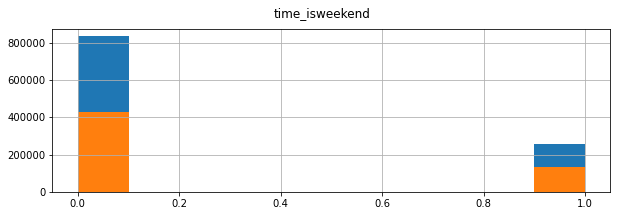

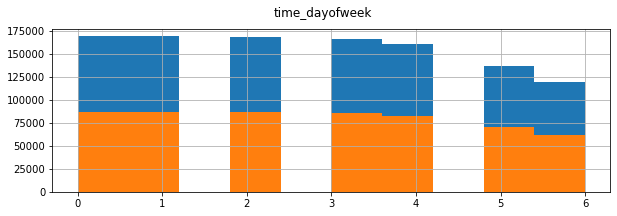

In [16]:
for c in ['ticket_type_nm', 'entrance_id', 'station_id', 'line_id',  
          'day', 'hours','time_isweekend', 'time_dayofweek']:
    plt.figure(figsize=(10,3))
    plt.suptitle(c)
    df[c].hist()
    valid[c].hist()


## Моделирование классов

Попытка смоделировать случайным образом распределение классов. Понятно, что это не будет решение.

In [49]:
temp__ = get_random_classes(df, 0, 30, valid.shape[0], 13)
# et_random_classes(df, nskip, nclasses, nlen, seed):

In [50]:
print(len(temp__),  pred_reg.shape[0],  pred_reg.shape[0] - len(temp__))

temp0 = [3002] * (pred_reg.shape[0] - len(temp__))
print(len(temp0))

temp = temp__.copy()

temp.append(temp0)
print(len(temp),  pred_reg.shape[0])

529367 561890 32523


# Обучение и тесты

## Выделим выборки

In [66]:
df = pd.read_csv("./train_dataset_train.csv")
df, df_bad_classes, df_good_classes, df_id_col = modifydata(df, 15000)
print(df_bad_classes.shape, df_good_classes.shape, df.shape)

Xa, ya = getFeaturesAndOutput(df)
X, y = getFeaturesAndOutput(df_good_classes)
Xb, yb = getFeaturesAndOutput(df_bad_classes)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.columns

(1058208, 16) (32813, 16) (1091021, 16)


Index(['ticket_type_nm', 'entrance_id', 'station_id', 'line_id', 'day',
       'hours', 'time_isweekend', 'time_dayofweek'],
      dtype='object')

новая выборка, где будет рандомить ответ

In [393]:
# df = pd.read_csv("./train_dataset_train.csv")
# df, df_bad_classes, df_good_classes, df_id_col, df_good_classes_fulldata = modifydata2(df, 15000)
# print(df_bad_classes.shape, df_good_classes.shape, df.shape, df_good_classes_fulldata.shape)

# Xa, ya = getFeaturesAndOutput(df)
# X, y = getFeaturesAndOutput(df_good_classes_fulldata)
# Xb, yb = getFeaturesAndOutput(df_bad_classes)

# y2 = pd.DataFrame()
# y2['label'] = X.pop('newlabel')
# y2['time_to_under'] = y['time_to_under']
# y, y2 = y2, y

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# print(X_train.columns)

(1058208, 16) (32813, 16) (1091021, 16) (1091021, 17)
Index(['ticket_type_nm', 'entrance_id', 'station_id', 'line_id', 'day',
       'hours', 'time_isweekend', 'time_dayofweek'],
      dtype='object')


Один из вариантов отфильтровать данные:

(не улучшило результат)

In [178]:
keys = {'label': 10000,
        'hours': 50000,
        'ticket_type_nm': 1000,
        'entrance_id': 1000,
        'station_id': 10000,
        'line_id': 50000
       }

# все элементы
temp = df["hours"].value_counts() < 0
bad_classes = temp.index[temp.values]
is_bad_classes = df['hours'].isin(bad_classes)
print( sum(is_bad_classes))

for k,v in keys.items():
    temp = df[k].value_counts() < v 
    bad_classes = temp.index[temp.values]
    is_bad_classes = df[k].isin(bad_classes) | is_bad_classes
    print(k,v, sum(is_bad_classes))    

    
df_bad_classes = df.drop( df[ ~is_bad_classes].index)
df_good_classes = df.drop( df[is_bad_classes].index)
print(df_bad_classes.shape, df_good_classes.shape, df.shape)

X, y = getFeaturesAndOutput(df_good_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.columns)

line_id 50000 0
label 10000 960373
hours 50000 994111
ticket_type_nm 1000 994680
entrance_id 1000 998193
station_id 10000 1055711
line_id 50000 1057124
(1057124, 16) (33897, 16) (1091021, 16)
Index(['ticket_type_nm', 'entrance_id', 'station_id', 'line_id', 'day',
       'hours', 'time_isweekend', 'time_dayofweek'],
      dtype='object')


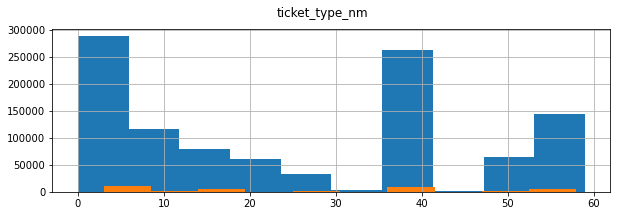

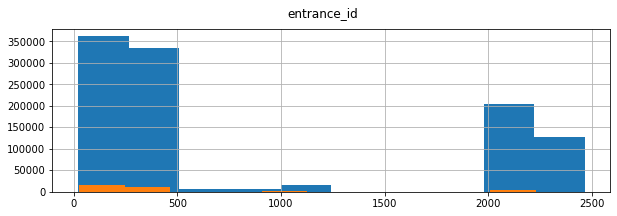

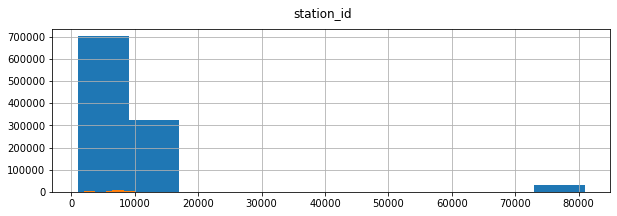

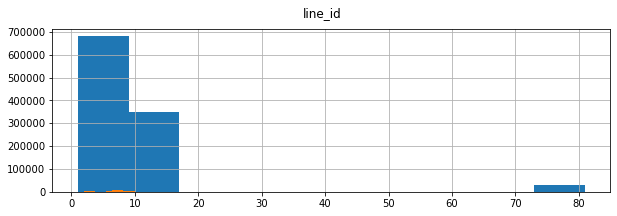

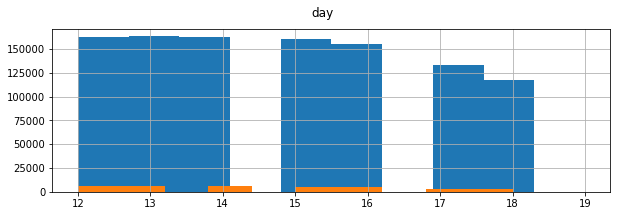

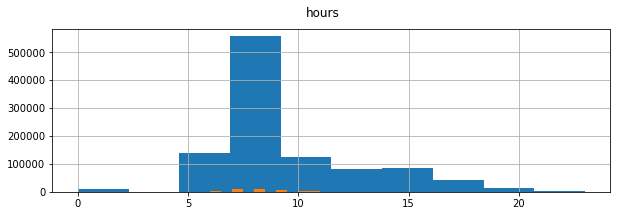

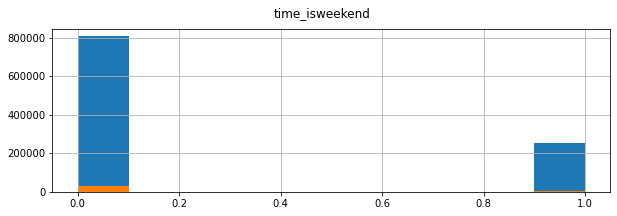

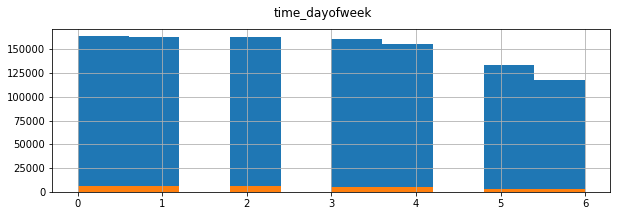

In [179]:
for c in ['ticket_type_nm', 'entrance_id', 'station_id', 'line_id',  
          'day', 'hours','time_isweekend', 'time_dayofweek']:
    plt.figure(figsize=(10,3))
    plt.suptitle(c)
    df_bad_classes[c].hist()
    df_good_classes[c].hist()

In [213]:
temp = df["label"].value_counts() < 17000
bad_classes = temp.index[temp.values]
is_bad_classes = df['label'].isin(bad_classes)
print(sum(is_bad_classes))

temp = df["label"].value_counts() > 13000
bad_classes = temp.index[temp.values]
is_bad_classes = df['label'].isin(bad_classes) & is_bad_classes
print(sum(is_bad_classes))

print(df.shape)
df = df.drop( df[is_bad_classes].index)
print(df.shape)

X, y = getFeaturesAndOutput(df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.columns)

1073749
55501
(1091021, 16)
(1035520, 16)
Index(['ticket_type_nm', 'entrance_id', 'station_id', 'line_id', 'day',
       'hours', 'time_isweekend', 'time_dayofweek'],
      dtype='object')


In [ ]:
X.head()

In [152]:
y_train

,time_to_under,label
686651,761.516667,6008
1028431,69.050000,6008
688416,248.833333,3002
76262,607.416667,3002
578240,610.816667,3002
...,...,...
552278,601.766667,3002
213498,675.400000,3002
373378,597.266667,6008
38839,594.300000,3002


## Обучение модели

### Для станции 

In [14]:
# %%time

# datalen = y_train.shape[0]
# chunksize = 10000

# clf = RandomForestClassifier(random_state=0, max_depth=15, n_jobs=1, warm_start=True)
# clf.fit(X_train[:chunksize], y_train["label"][:chunksize])

# i = 0
# while i < datalen:
#     clf.fit(X_train[i:i+chunksize], y_train["label"][i:i+chunksize])
#     i = i + chunksize


In [9]:
%%time

clf = RandomForestClassifier(random_state=0, max_depth=10, n_estimators=200, n_jobs=4)
clf.fit(X_train, y_train["label"])

# festo ~4min  n_jobs=2

Wall time: 738 ms


RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=4, random_state=0)

In [248]:
# классификатор специально для плохих классов
clf_bad = RandomForestClassifier(random_state=0, max_depth=10, n_estimators=200, n_jobs=-1)
clf_bad.fit(Xb, yb["label"])


RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=-1,
                       random_state=0)

In [20]:
# import pickle

# with open('./clf.data', 'wb') as f:
#     pickle.dump(clf, f)

## Среднее

In [92]:
rs = [150, 13, 18, 19, 86352, 264234, 96340, 131313, 18603, 82735]
print(len(rs))
preds = []
print('Classification:')

for i in range(len(rs)):
    print('i =',i)
    clf = RandomForestClassifier(random_state=i, max_depth=15, n_estimators=200, n_jobs=-1)
    X_train, X_val, y_train, y_val = train_test_split(X, y['label'], train_size=0.8, random_state=i)

# запуск обучения
    clf.fit(X_train, y_train)
    scores = cross_validate(clf, X.values, y['label'].values, scoring='recall_macro', cv=3, n_jobs=-1, return_train_score=True)
    print('Train\t', scores['train_score'].mean(), scores['train_score'].std())
    print('Test\t', scores['test_score'].mean(), scores['test_score'].std())
    print('--------------')
    
    pred = clf.predict_proba(X_test)
    preds.append(pred)
    
#  Усредняем прогнозы
pred = np.mean(preds, axis=0)

pred_clf = np.argmax(pred, axis=1)   # maxed argument
pred_clf = clf.classes_[pred_clf]   # maxed class


10
Classification:
i= 0
Train	 0.8749724233358741 0.010747035227357914
Test	 0.5173280633244782 0.014700114910733775
--------------
i= 1
Train	 0.8750304467719098 0.010747670781230175
Test	 0.5154325400961209 0.018694343278111158
--------------
i= 2
Train	 0.8750560098716745 0.010611439186588509
Test	 0.5107557750887247 0.020724952073598837
--------------
i= 3
Train	 0.8745317931198096 0.011031184772232713
Test	 0.518172367080509 0.015153194813525478
--------------
i= 4
Train	 0.8759552012097617 0.011361707976427583
Test	 0.5113355835838999 0.018214915726676793
--------------
i= 5
Train	 0.8754228919478737 0.011619021824199468
Test	 0.514219618937055 0.016498301598143576
--------------
i= 6
Train	 0.8753584223276091 0.01014845580821592
Test	 0.5195383990204179 0.015456450334129637
--------------
i= 7
Train	 0.8749450308383636 0.010827194614879172
Test	 0.5219074942729504 0.01652809770636295
--------------
i= 8
Train	 0.8757702804933523 0.010372046750010952
Test	 0.5116040719445519 0.01

array([6008, 6008, 6008, ..., 3002, 6008, 6008], dtype=int64)

## lightgbm

In [67]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(y['label'])
ylabel = le.transform(y['label'])

# print(le.fit(y['label']),
# le.classes_,
# le.transform(y['label']),
# le.inverse_transform([0, 0, 1, 2]))


In [68]:
np.unique(ylabel)

array([0, 1], dtype=int64)

Wall time: 1.54 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

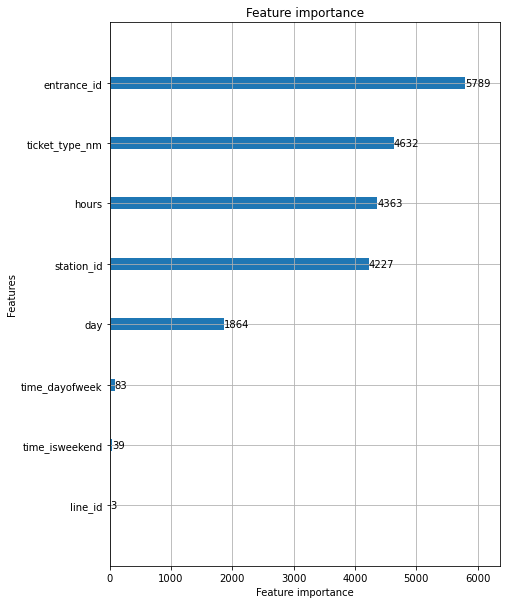

In [76]:
%%time

import lightgbm as lgb

# clf = lgb.LGBMClassifier(n_estimators=1500, num_leaves=10, learning_rate=0.05, colsample_bytree=0.75, verbose=1000,
#                          subsample=0.75, random_state=13, metric='multi_logloss', objective='multiclass', n_jobs=-1)

clf = lgb.LGBMClassifier(n_estimators=1500, num_leaves=15, verbose=1000,
                         random_state=13, metric='f1', objective='binary', n_jobs=-1)
clf.fit(X, ylabel, eval_metric='recall')
# multi_error

lgb.plot_importance(clf, figsize=(7,10))

In [138]:
clf.best_score_

defaultdict(dict, {})

### Для времени

In [10]:
%%time
reg = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=200, n_jobs=-1)

reg.fit(X_train, y_train["time_to_under"])

# фесто 45с n_jobs=-1

Wall time: 1.01 s


RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1, random_state=0)

In [21]:
# import pickle

# with open('./reg.data', 'wb') as f:
#     pickle.dump(reg, f)

## Линейная

In [20]:
# %%time 

# from sklearn.linear_model import LinearRegression

# reg = LinearRegression(n_jobs=-1)
# reg.fit(X_train, y_train["time_to_under"])

CPU times: user 353 ms, sys: 23.3 ms, total: 376 ms
Wall time: 94.3 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

## lightgbm

In [70]:
%%time

# reg = lgb.LGBMRegressor(n_estimators=1500, num_leaves=10, learning_rate=0.05, colsample_bytree=0.75, verbose=100,
#                          subsample=0.75, random_state=13, metric='r2', objective='regression', n_jobs=-1)

reg = lgb.LGBMRegressor(n_estimators=1500, num_leaves=10, verbose=1,
                        random_state=13, metric='r2', objective='regression', n_jobs=-1)

reg.fit(X, y['time_to_under'], eval_metric='r2')

reg.best_score_

Wall time: 1.12 s


defaultdict(dict, {})

## Среднее по прогнозу

In [ ]:
rs = [150, 13, 18, 19, 86352, 264234, 96340, 131313, 18603, 82735]
print(len(rs))
preds = []

for i in range(len(rs)):
    print(i)
#     est = lgb.LGBMClassifier(n_estimators=150, random_state=i, num_leaves=50, max_depth=20, n_jobs=-1)
#     est.fit(train[full_list_of_features], train['higher_education'])
#     score = cross_val_score(est, train[full_list_of_features], train['higher_education'], scoring='roc_auc', cv=5, n_jobs=-1)

    X_train, X_val, y_train, y_val = train_test_split(train[full_list_of_features], train['higher_education'], 
                                                       train_size=0.8, 
                                                       random_state=i)

# запуск обучения
    est.fit(X_train, y_train,
                        eval_set=(X_val, y_val),
                        verbose=500, plot=False, early_stopping_rounds=600)
    print(est.get_best_score())
    print('--------------')
    
    pred = est.predict_proba(test[full_list_of_features])
    preds.append(pred)
    
#  Усредняем прогнозы
print(np.mean(preds, axis=0).shape)
pred = np.mean(preds, axis=0)

## Оценка точности

In [71]:
from sklearn.metrics import recall_score, r2_score

pred_class = clf.predict(X_test)
pred_reg = reg.predict(X_test)


#  for LGBM inverse transform of classes
if type(clf) == lgb.sklearn.LGBMClassifier:
    pred_class = le.inverse_transform(pred_class)
    

rs = recall_score(y_test["label"], pred_class , average='macro')
r2 = r2_score(y_test["time_to_under"], pred_reg)
score = 0.5 * rs +  0.5 * r2

print(rs, r2, score)

0.8072741377933442 0.612112555597087 0.7096933466952156


In [ ]:
# 0.4897555334746157   -- baseline
# 0.2678758686368177   -- baseline, обучение на всех данных.  На паблике 0.092150

# Recall, R2, score
# 2*0.0028946815886393275 0.4765418328846045 0.2397182572366219   -- logit, linreg  public  -0.177917
# 0.051367635290150336 0.5337106363746371 0.2925391358323937 -- RandomForestClassifier, RandomForestRegressor, полный набор
# 0.0038071101519124456 0.5337099924062669 0.2687585512790897 -- RandomForestClassifier, RandomForestRegressor, df["time_to_under"] < 900


# 0.1003784996172645 0.5477282066729828 0.3240533531451237 -- RandomForestClassifier, bad_classes
# 0.7298980069136254 0.5175243103995155 0.6237111586565705   # stationsize < 15000
# 0.12490370842962603 0.5237048533791078 0.3243042809043669  # stationsize < 7000
# 0.240904745579802 0.5105320359587164 0.3757183907692592    # stationsize < 10000  
# 0.7268148266459791 0.5187556104925162 0.6227852185692476   # stationsize < 15000  no id 
#     for ALL: 0.00546378514749871 0.4575358691068202 0.23149982712715947

# LGBM, # stationsize < 7000
# 0.1710043969339049 0.5347006858367624 0.3528525413853337
# Public Score = 0.042972

# LGBM, stationsize < 10000
# 0.06935987873302325 0.5263155078550112 0.29783769329401727
# Public Score = 0.001329

# LGBM, stationsize < 15000
# 0.8072741377933442 0.612112555597087 0.7096933466952156
# Public Score = 0.001329


In [72]:
%%time
# метри на всех данных, включая обучение
from sklearn.metrics import recall_score, r2_score

pred_class = clf.predict(Xa)
pred_reg = reg.predict(Xa)

#  for LGBM inverse transform of classes
if type(clf) == lgb.sklearn.LGBMClassifier:
    pred_class = le.inverse_transform(pred_class)
    

rs = recall_score(ya["label"], pred_class , average='macro')
r2 = r2_score(ya["time_to_under"], pred_reg)
score = 0.5 * rs +  0.5 * r2

print(rs, r2, score)

0.005859754923904208 0.48805489846310646 0.24695732669350534
Wall time: 10.1 s


In [77]:
%%time
# метрики на обучающей выборке

scores = cross_validate(clf, X.values, y['label'].values, scoring='recall_macro', cv=5, n_jobs=-1, return_train_score=True)
print('Classification:')
print('Train\t', scores['train_score'].mean(), scores['train_score'].std())
print('Test\t', scores['test_score'].mean(), scores['test_score'].std())


scores1 = cross_validate(reg, X.values, y['time_to_under'].values, scoring='r2', cv=5, n_jobs=-1, return_train_score=True)
print('Regression:')
print('Train\t', scores1['train_score'].mean(), scores1['train_score'].std())
print('Test\t', scores1['test_score'].mean(), scores1['test_score'].std())

print(0.5*scores1['test_score'].mean() + 0.5*scores['test_score'].mean())

Classification:
Train	 0.8478287041983072 0.004871837862916295
Test	 0.49947605530714956 0.09540900794705379
Regression:
Train	 0.6213304116864278 0.0075651389258668015
Test	 0.4822871210382475 0.0667711249642018
0.49088158817269856
Wall time: 10.1 s


In [ ]:
## CV metrics
# < 900
# Class           Train 0.13561506174050203 0.003919650939196688,  Test 0.05748999133734326 0.02317111428466088
# Regress         Train 0.6235695720322265 0.01699774672075998,    Test 0.45812485786452795 0.028581941528906817

# stationsize < 1000
# Classification: Train 0.06411120481666817 0.0024074551124603186, Test 0.027039440606936464 0.011243727223666317
# Regression:     Train 0.579278188403807 0.01587261373976514,     Test 0.46565763045506064 0.035428402233769515
# Public Score = 0.141005

# stationsize < 15000
# Classification: Train	 0.7766608130174626 0.0071032513880352225  Test	 0.5059780312150269 0.06739058625640744
# Regression:     Train	 0.7705591530210607 0.008838076905600432   Test	 0.4577849308723593 0.03791206577049757
# 0.4818814810436931  Wall time: 6.27 s
# Public Score = 0.173457

# stationsize < 7000
# Classification: Train	 0.13900015725605608 0.0037958818071982866 Test	 0.05605391160258757 0.0306836823057727
# Regression:     Train	 0.60357617541174 0.015187794866878612     Test	 0.45970415872525844 0.03722895441220533
# 0.257879035163923 Wall time: 2min 14s
# Public Score = 0.133424

# stationsize < 10000,  no ID
# Classification: Train	 0.2787722778628954 0.004338544045341835 Test	 0.15528023132256066 0.041954169158995115
# Regression:     Train	 0.6416177727962342 0.014415805234755505 Test	 0.4782292343470019 0.03415935935014842
# 0.3167547328347813 Wall time: 23.2 s
# Public Score = 0.244189

# stationsize < 15000,  no ID
# Classification: Train	 0.7720645710811282 0.005873207117476362 Test	 0.5623202763660694 0.09237584979308287
# Regression:     Train	 0.7622781640795253 0.007740854170605912 Test	 0.4915200822784128 0.050455129262114755
# 0.5269201793222411
# Public Score = 0.264127

# фильтрация мелких ,no id, stationsize < 15000,
# Classification: Train	 0.7719039254587703 0.006477676816194996 Test	 0.5638129312667978 0.09450788579681955
# Regression:     Train	 0.7646547568538787 0.007538764947371263 Test	 0.47698701614447636 0.04871780454952521
# 0.5203999737056371

# фильтрация мелких ,no id, stationsize < 10000
# Classification: Train	 0.27941318295671713 0.0045865872402338845 Test	 0.15562130936292462 0.04268192163476864
# Regression:     Train	 0.6397308303975837 0.014399857483422976   Test	 0.47370939807611034 0.03220779788909969
# 0.3146653537195175

# фильтрация мелких, сильно для стацнии < 50000, no id, stationsize < 10000
# Classification: Train	 0.33213655888382176 0.007067528909779927  Test	 0.19803723357701755 0.04791679899776778
# Regression:     Train	 0.49269350782515353 0.015896222111523712  Test	 0.1938500070764645 0.028002819079490496
# 0.195943620326741

# no id, stationsize < 10000
# Classification: Train	 0.34367501764037556 0.005250117309535671  Test	 0.34321400717351574 0.029812380436278697
# Regression:     Train	 0.5649646048741646 0.014121051506749503   Test	 0.4813427666807506 0.027425559897654557
# 0.41227838692713314


# LGBM
# stationsize < 10000
# Classification: Train	 0.33192901427429555 0.005872930829746373 Test	 0.11362338163112295 0.05386222823723618
# Regression:     Train	 0.5397642642266066 0.012073370061145386  Test	 0.4547109149300333 0.045197869452318525
# 0.2841671482805781 Wall time: 6min 8s
# Public Score = 0.001329

# stationsize < 15000, no id, настройки не урезал
# Classification:   Train	 0.8230786648944118 0.005978248075112078  Test	 0.5003057647367186 0.09223682436914307
# Regression:       Train	 0.6213304116864278 0.0075651389258668015 Test	 0.4822871210382475 0.0667711249642018
# 0.4912964428874831

### classification_report

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test["label"], pred_class))

ValueError: Found input variables with inconsistent numbers of samples: [9844, 561890]

In [102]:
# классы, которые плохо прогнозируются

from sklearn.metrics import multilabel_confusion_matrix
mcm = multilabel_confusion_matrix(y_test["label"], pred_class)

bad_classes_classes = sorted(y_test["label"].unique())   #  список классов

bad_classes = []
for i in range(len(mcm)):
    if mcm[i][1,1] <= 1:
        bad_classes.append(bad_classes_classes[i])
#     print(mcm[i][1,1])

print(len(bad_classes),'/',len(bad_classes_classes))

0 / 10


## ищем коилчество посещений ,которое не подходит

In [19]:
%%time
#  На самом деле результаты для метрики здесь нельзя соизмерять друг с другом, потому что они получены 
# для разного количества данных и количества классов

thrs = [15000, 13000, 12000, 11000, 10000, 4000, 3000, 2500, 2000, 1000];

for t in thrs:
    print('\n', t)
    df = pd.read_csv("./train_dataset_train.csv")
    df, df_bad_classes, df_good_classes, _ = modifydata(df, t)
    print(df_bad_classes.shape, df_good_classes.shape, df.shape)

    X, y = getFeaturesAndOutput(df_good_classes)

    scores = cross_validate(RandomForestClassifier(random_state=0, max_depth=2, n_estimators=3, n_jobs=2),
                            X.values, y['label'].values, scoring='recall_macro', cv=5, n_jobs=-1, return_train_score=True)
    print('Classification:')
    print('Train\t', scores['train_score'].mean(), scores['train_score'].std())
    print('Test\t', scores['test_score'].mean(), scores['test_score'].std())


    scores1 = cross_validate(RandomForestRegressor(random_state=0, max_depth=5, n_estimators=3, n_jobs=-1), 
                            X.values, y['time_to_under'].values, scoring='r2', cv=5, n_jobs=-1, return_train_score=True)
    print('Regression:')
    print('Train\t', scores1['train_score'].mean(), scores1['train_score'].std())
    print('Test\t', scores1['test_score'].mean(), scores1['test_score'].std())
    
    print(0.5*scores1['test_score'].mean() + 0.5*scores['test_score'].mean())



 15000
(1058208, 16) (32813, 16) (1091021, 16)
Classification:
Train	 0.6615339137852585 0.005059847554502546
Test	 0.6418465304724335 0.04607952994852787
Regression:
Train	 0.5044078919422119 0.009683937287038615
Test	 0.45737820045422045 0.04217346652860588
0.5496123654633269

 14000
(1058208, 16) (32813, 16) (1091021, 16)
Classification:
Train	 0.6615339137852585 0.005059847554502546
Test	 0.6418465304724335 0.04607952994852787
Regression:
Train	 0.5044078919422119 0.009683937287038615
Test	 0.45737820045422045 0.04217346652860588
0.5496123654633269

 13000
(1018248, 16) (72773, 16) (1091021, 16)
Classification:
Train	 0.32554166348475844 0.008079247500376521
Test	 0.3014140490092281 0.04008235990749095
Regression:
Train	 0.48383831179196407 0.00856947465655451
Test	 0.44998028521064093 0.028156622795336157
0.3756971671099345

 12000
(993191, 16) (97830, 16) (1091021, 16)
Classification:
Train	 0.23330974442286592 0.007064539987908854
Test	 0.21680676983896716 0.01384055451070391
R

In [ ]:
# RandomForestClassifier(random_state=0, max_depth=2, n_estimators=3, n_jobs=2)
# RandomForestRegressor(random_state=0, max_depth=5, n_estimators=3, n_jobs=-1)

# 15000
# (1058208, 17) (32813, 17) (1091021, 17)
# Classification:
# Train	 0.6630141494841523 0.005015396747037869
# Test	 0.6284705632749639 0.06470628077807934
# Regression:
# Train	 0.5050368702295558 0.010017920606690248
# Test	 0.45508652839366565 0.04191400851943784
# 0.5417785458343147
# 10000
# (960373, 17) (130648, 17) (1091021, 17)
# Classification:
# Train	 0.16350063117005967 0.00873790225084011
# Test	 0.15287697952221507 0.012895761612797646
# Regression:
# Train	 0.49051613971859326 0.01152793082141878
# Test	 0.44214214910984617 0.0339202204417001
# 0.2975095643160306
# 4000
# (310287, 17) (780734, 17) (1091021, 17)
# Classification:
# Train	 0.016543048942274534 0.0008070977513912614
# Test	 0.0155692845252488 0.0017321273921953304
# Regression:
# Train	 0.5041447398778537 0.015033215318697743
# Test	 0.46208966065398344 0.03749244325951907
# 0.23882947258961612
# 3000
# (211983, 17) (879038, 17) (1091021, 17)
# Classification:
# Train	 0.013003748601015594 0.00041964568072929657
# Test	 0.012212832403053436 0.001284301657597231
# Regression:
# Train	 0.5051190421655127 0.015117351987881977
# Test	 0.46240187468554217 0.036515393198589194
# 0.2373073535442978
# 2500
# (148150, 17) (942871, 17) (1091021, 17)
# Classification:
# Train	 0.014340606526052336 0.0005575487381591637
# Test	 0.012661205056841124 0.0023962034225589956
# Regression:
# Train	 0.5066962168557723 0.015257533653746441
# Test	 0.4640421932173437 0.03670719783895243
# 0.23835169913709242
# 2000
# (100456, 17) (990565, 17) (1091021, 17)
# Classification:
# Train	 0.016005714269079478 0.0007617559321862121
# Test	 0.015318456021413285 0.002668709208224399
# Regression:
# Train	 0.5068023807651202 0.014190961973010398
# Test	 0.4640020232059955 0.0356420105391075
# 0.2396602396137044
# 1000
# (23906, 17) (1067115, 17) (1091021, 17)
# Classification:
# Train	 0.012703545948319666 0.0005490095579516091
# Test	 0.011083844797861201 0.001307461956030289
# Regression:
# Train	 0.5076831617682902 0.014940686562873997
# Test	 0.4644092289732017 0.03448728003784514
# 0.23774653688553143
# Wall time: 1min 26s

##  что выводит на классах, на которых не учился

In [304]:
y['label'].unique()

array([6008, 3002], dtype=int64)

In [305]:
yb['label'].unique()

array([ 8001,  9011,  7022,  2022,  2017, 11012, 15001,  7014,  5007,
        6018,  5009,  5008,  3015,  7023,  8003, 11013, 11020,  9022,
        1012,  5005,  6001,  8005,  1020,  9012,  3016,  9009, 11003,
       10018, 12006,  2016,  3014,  8007,  6022,  4002,  2008,  1007,
        8006,  3011, 11007,  3018,  5003,  1016, 10003,  5011,  7021,
        9020,  9021,  8008,  2023,  5001,  3017,  4004,  7003,  6006,
        6023,  7020,  4003,  1005,  7019,  6016,  2024,  1026, 10007,
       10022,  4001, 10023,  3001,  2010, 15005, 11006, 12004,  2007,
        6014,  7002,  7008,  2013,  5010,  2018,  2014,  7015,  9007,
        6020, 14003,  9010, 14016, 11019,  9004,  9019,  7017,  6009,
       12003,  2015,  8002,  3005,  1006,  5006, 10001,  5002,  1022,
        1014, 10012,  7013,  9001,  3006, 12002,  1003,  3010,  4012,
        1008, 10009,  2003,  1023,  6013, 11004,  2006,  1015,  9002,
        7005,  6002,  9024,  7009,  6011, 14021, 14018,  4010,  3009,
       14002,  5004,

In [323]:
clf.predict_proba(X[:10])


array([[0.60321218, 0.39678782],
       [0.56301594, 0.43698406],
       [0.43624281, 0.56375719],
       [0.27743307, 0.72256693],
       [0.23171045, 0.76828955],
       [0.56408939, 0.43591061],
       [0.5994122 , 0.4005878 ],
       [0.6257579 , 0.3742421 ],
       [0.3055914 , 0.6944086 ],
       [0.31694442, 0.68305558]])

In [324]:
clf.predict_proba(Xb[:10])

array([[0.56064996, 0.43935004],
       [0.60462478, 0.39537522],
       [0.65865437, 0.34134563],
       [0.62849979, 0.37150021],
       [0.65740405, 0.34259595],
       [0.64785623, 0.35214377],
       [0.1493394 , 0.8506606 ],
       [0.35078276, 0.64921724],
       [0.61944707, 0.38055293],
       [0.64357045, 0.35642955]])

суть -- надо вводить 3й класс ,фиктивный, который не относится к двум большим

# Submit

In [20]:
# дообучение на всех отобранных (т.е. только good) тренировочных данных, включая тест

# clf.fit([X_train, X_test], [y_train["label"], y_test['label']])
# reg.fit([X_train, X_test], [y_train["time_to_under"], y_test['time_to_under']])

clf.fit(X, y['label'])
reg.fit(X, y['time_to_under'])

RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1, random_state=0)

In [12]:
valid = pd.read_csv("./test_dataset_test.csv")
valid, valid_idcol = modifydata(valid, 0)   # for test 0 is no matter

X = getFeaturesAndOutput(valid)

pred_class = clf.predict(X)
pred_reg = reg.predict(X)

#  for LGBM inverse transform of classes
if type(clf) == lgb.sklearn.LGBMClassifier:
    pred_class = le.inverse_transform(pred_class)

In [116]:
# submit_df = pd.DataFrame([valid.id, pred_reg, pred_class], columns=['id', 'time_to_under', 'label'])
submit_df = pd.DataFrame(columns=['id', 'time_to_under', 'label'], index=None)
# submit_df.set_index('id', inplace=True)

submit_df['id'] = valid_idcol
submit_df['time_to_under'] = pred_reg
submit_df['label'] = pred_class

submit_df.to_csv('submit.csv', index=False)

submit_df.head()



,id,time_to_under,label
0,1091022,787.038331,3002
1,1091023,653.769792,3002
2,1091024,528.901100,6008
3,1091025,840.944255,3002
4,1091026,787.038331,3002


## среднее

In [118]:
df = pd.read_csv("./train_dataset_train.csv")
# df, df_bad_classes, df_good_classes, df_id_col = modifydata(df, 15000)
df, df_bad_classes, df_good_classes, df_id_col = modifydata(df, 13500)
print(df_bad_classes.shape, df_good_classes.shape, df.shape)

valid = pd.read_csv("./test_dataset_test.csv")
valid, valid_idcol = modifydata(valid, 0)   # for test 0 is no matter
X = getFeaturesAndOutput(valid)

# Xa, ya = getFeaturesAndOutput(df)
XX, yy = getFeaturesAndOutput(df_good_classes)
# Xb, yb = getFeaturesAndOutput(df_bad_classes)

(1044450, 16) (46571, 16) (1091021, 16)


In [119]:
%time

rs = [150, 13, 18, 19, 86352, 264234, 96340, 131313, 18603, 82735]
# rs = [150, 13, 18, 19]
print(len(rs))
preds = []

print('Classification:')

for i in range(len(rs)):
    print('i =',i)
    clf = RandomForestClassifier(random_state=i, max_depth=15, n_estimators=200, n_jobs=-1)
    X_train, X_val, y_train, y_val = train_test_split(XX, yy['label'], train_size=0.8, random_state=i)
    clf.fit(X_train, y_train)
    scores = cross_validate(clf, XX.values, yy['label'].values, scoring='recall_macro', cv=3, n_jobs=-1, return_train_score=True)
    print('Train\t', scores['train_score'].mean(), scores['train_score'].std())
    print('Test\t', scores['test_score'].mean(), scores['test_score'].std())
    print('--------------')
    
    pred = clf.predict_proba(X)
    preds.append(pred)
    
#  Усредняем прогнозы
pred = np.max(preds, axis=0)

pred_class = np.argmax(pred, axis=1)   # maxed argument
pred_class = clf.classes_[pred_class]   # maxed class





Wall time: 0 ns
10
Classification:
i = 0
Train	 0.7710415365521138 0.007005900821573081
Test	 0.3944154290162822 0.04508333015078256
--------------
i = 1
Train	 0.7704146458334257 0.009595938969837327
Test	 0.4014842876177247 0.048572576383084445
--------------
i = 2
Train	 0.7699061668253852 0.008571027934568827
Test	 0.3919147645106043 0.04386322493882258
--------------
i = 3
Train	 0.770107622457309 0.009353139221106466
Test	 0.3971123808643439 0.045768330765118305
--------------
i = 4
Train	 0.7707277651756931 0.008799159987043895
Test	 0.3980064260602496 0.04652467049095687
--------------
i = 5
Train	 0.7699023958134927 0.008596531133543263
Test	 0.39835035178794787 0.04773559815960473
--------------
i = 6
Train	 0.7693832751748809 0.009743306188999394
Test	 0.39690869036265947 0.048374657512791165
--------------
i = 7
Train	 0.7697438819388299 0.007906358919790184
Test	 0.39433184251372944 0.04820161668414499
--------------
i = 8
Train	 0.7691132099831356 0.009954988228117998
Tes

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [ ]:

preds = []
print('\nRegression:')
for i in range(len(rs)):
    print('i =',i)
    reg = RandomForestRegressor(random_state=i, max_depth=15, n_estimators=200, n_jobs=-1)
    X_train, X_val, y_train, y_val = train_test_split(XX, yy['time_to_under'], train_size=0.8, random_state=i)
    reg.fit(X_train, y_train)
    scores = cross_validate(reg, XX.values, yy['label'].values, scoring='r2', cv=3, n_jobs=-1, return_train_score=True)
    print('Train\t', scores['train_score'].mean(), scores['train_score'].std())
    print('Test\t', scores['test_score'].mean(), scores['test_score'].std())
    print('--------------')
    
    pred = reg.predict(X)
    preds.append(pred)
    
pred_reg = np.mean(preds, axis=0)  #  Усредняем прогнозы


Regression:
i = 0
Train	 0.5833257996459591 0.002053568221205675
Test	 0.3056017708711945 0.04032234284111202
--------------
i = 1
